### Dielectric cylinder

In [1]:
from GDM_PCE import *

In [2]:
np.random.seed(1)

#### Load data

In [3]:
n_samples_ = [150, 400, 800]

In [4]:
Error = []
N_clusters = []
Y_real, Y_recon, Diff, L2, R2, g_all, l_all, coord_all, X_all = [], [], [], [], [], [], [], [], []

for i in range(len(n_samples_)):
    
    print('----Iteration: {} ----'.format(i))
    
    n_samples = n_samples_[i]

    # Probability distributions of input parameters
    pdf1 = Uniform(loc=0.2, scale=0.5)  # cylinder radius
    pdf2 = Uniform(loc=8, scale=10)  # strength of electric field
    margs = [pdf1, pdf2]
    joint = JointInd(marginals=margs)
    
    # Draw samples
    x = joint.rvs(n_samples)
    if i == 0:
        x_ = x[:100,:]
    
    # Generate multi-dimensional output
    ax, bx, ay, by = -1, 1, -1, 1
    grid_points_x, grid_points_y = 80, 80
    gridx = np.linspace(ax, bx, grid_points_x)
    gridy = np.linspace(ay, by, grid_points_y)
    xx, yy = np.meshgrid(gridx, gridy)

    out = []
    for i in range(x.shape[0]):
        vfunc = np.vectorize(function)
        u = vfunc(xx, yy, r0=x[i, 0], efield=x[i, 1])
        out.append(u)

    np.savez('data/electric_data.npz', X=x, Y=out)

    file = np.load('data/electric_data.npz')
    x = file['X']
    data = file['Y']
    
    start_time = time.time()

    g, coord, Grass,  residuals, index, evals = GDMaps(data=data, n_evecs=15, n_parsim=4, p='max').get()  # Perform GDMAps
    pce, error = PceModel(x=x, g=g, dist_obj=joint, max_degree=3, verbose=False).get()  # Perform PCE on the manifold
    # print('Error of PCE:', error)

    print("--- Surrogate - %s seconds ---" % (time.time() - start_time))
    
    # Adaptive clustering
    start_time = time.time()
    mat, indices, kmeans, L, n_clust, error_cl, clusters = AdaptClust(n_clust_max=50, Gr_object=Grass, data=g)
    print("--- Adaptive clustering - %s seconds ---" % (time.time() - start_time))
    
    Error.append(error_cl)
    N_clusters.append(clusters)
    g_all.append(g)
    l_all.append(L)
    coord_all.append(coord)
    
    # Interpolators
    models_all, pce_sigmas, dims = Interpolators(x=x, data=g, mat=mat, indices=indices, n_clust=n_clust, Gr=Grass, joint=joint)
      
    # Predictions
    n_pred = 10000
    x_pred = joint.rvs(n_pred)  # new samples
    x_pred[:100,:] = x_
    
    X_all.append(x_pred)
    
    start_time = time.time()   

    y_real = []
    for k in range(x_pred.shape[0]):
        vfunc = np.vectorize(function)  # Dielectric cylinder
        y_real.append(vfunc(xx, yy, r0=x_pred[k, 0], efield=x_pred[k, 1]))

    Y_real.append(y_real)
    print("--- Comp. model cost - %s seconds ---" % (time.time() - start_time))

    start_time = time.time()   
    
    y_recon, l2, r2, diff = Prediction(x_pred=x_pred, y_real=y_real, models_all=models_all, kmeans=kmeans, mat=mat,
                                               pce=pce, pce_sigmas=pce_sigmas, Gr=Grass, dims=dims)

    Y_recon.append(y_recon)
    Diff.append(diff)
    L2.append(l2)
    R2.append(r2)
    
    print("--- Out-of-sample predictions with GDMaps PCE - %s seconds ---" % (time.time() - start_time))
    print('-------------------------------------------------------------------------------')
    print('')
    


----Iteration: 0 ----
Grassmann projection rank is:  30
--- Surrogate - 1.1575927734375 seconds ---
A cluster of less than 5 points was detected. The algorithm stopped.
--- Adaptive clustering - 117.12238502502441 seconds ---
Validation error of PCE of sigmas:  [7.270000e-05 9.916000e-03 2.602800e-03 6.823000e-03 1.447820e-02
 2.283050e-02 1.847490e-02 1.386300e-02 1.839560e-02 1.964700e-02
 1.855510e-02 2.064070e-02 3.395030e-02 5.301660e-02 7.731460e-02
 1.004505e-01 1.306159e-01 1.758982e-01 3.200532e-01 5.832630e-01
 8.029990e-01 6.672470e-01 7.464308e-01 6.446291e-01 7.083699e-01
 6.774933e-01 6.531818e-01 6.990175e-01 5.804810e-01 7.132529e-01]
--- Comp. model cost - 168.00247025489807 seconds ---
--- Out-of-sample predictions with GDMaps PCE - 942.567193031311 seconds ---
-------------------------------------------------------------------------------

----Iteration: 1 ----
Grassmann projection rank is:  30
--- Surrogate - 5.080448865890503 seconds ---
A cluster of less than 5 po

In [5]:
# Save results
import os
if not os.path.exists('results'):
    os.makedirs('results')
np.savez('results/Results-Example-1.npz', x1=Error, x2=N_clusters, x3=g_all, x4=l_all, x5=coord_all, x6=Y_real, x7=Y_recon, x8=Diff, x9=L2, x10=R2)

# Load file
file_res = np.load('results/Results-Example-1.npz', allow_pickle=True)
Error = file_res['x1']
N_clusters = file_res['x2']
g_all = file_res['x3']
l_all = file_res['x4']
coord_all = file_res['x5']
Y_real = file_res['x6']
Y_recon = file_res['x7']
Diff = file_res['x8']
L2 = file_res['x9']
R2 = file_res['x10']

### Plot error vs number of clusters

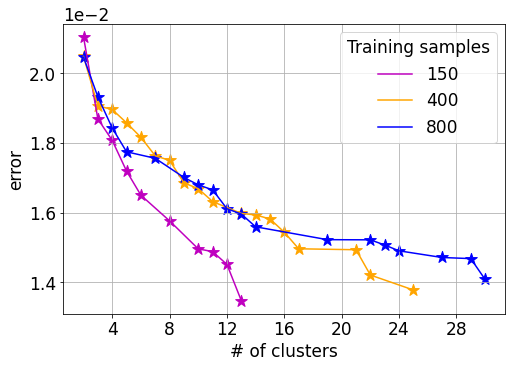

In [6]:
import os
if not os.path.exists('figures'):
    os.makedirs('figures')
    
os.makedirs('figures/Example1')

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)
col = ['m', 'orange', 'b']

for i in range(len(n_samples_)):
    plt.plot(N_clusters[i], Error[i], c=col[i], label='{}'.format(n_samples_[i]))
    plt.scatter(N_clusters[i], Error[i], c=col[i], marker='*', s=150)

plt.ylabel('error')
plt.xlabel('# of clusters')
plt.legend(title='Training samples')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.savefig('figures/Example1/Error-vs-number-of-clusters.png', bbox_inches='tight', dpi=300)

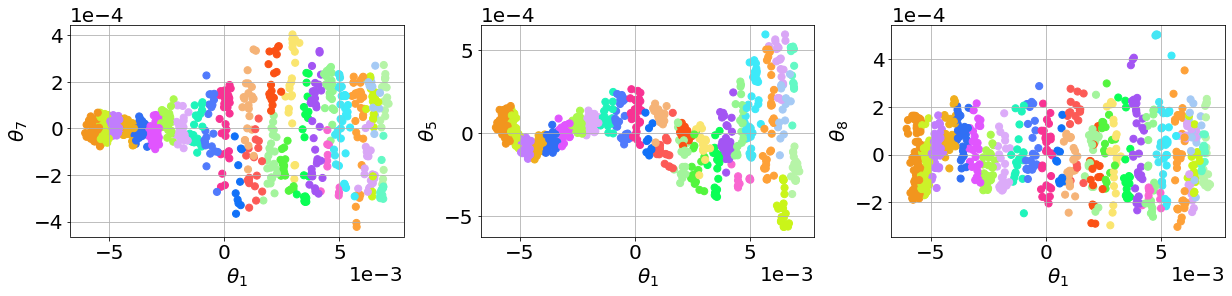

In [7]:
# Plot diffusion coordinates of the last n_samples_
plt.rcParams.update({'font.size': 20})

# Choose the last n_samples_
g = g_all[-1]
L = l_all[-1]
coord = coord_all[-1]

nlabels = np.unique(L).shape[0]
cmap = rand_cmap(nlabels=nlabels, type='bright', first_color_black=False, verbose=False)

comb1 = list(it.combinations(list(coord), 2))
comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))

# Plot first three plots
if coord.shape[0] > 2:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,4), constrained_layout=True)
    # fig.suptitle('Diffusion coordinates for {} training samples ({} clusters)'.format(n_samples_[-1], N_clusters[-1][-1]), fontsize=24)
    j = 0
    for i in range(3):
        ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], s=50, c=L, cmap=cmap)
        ax[i].set_xlabel(r'$\theta_{}$'.format(comb1[j][0]))
        ax[i].set_ylabel(r'$\theta_{}$'.format(comb1[j][1]))
        ax[i].grid('True')
        ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        # plt.legend()
        # ax[i].set_title('Training realizations: {}'.format(trunc[i]))
        j += 1
        #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
    plt.savefig('figures/Example1/Diffusion-coord-cylinder.png', bbox_inches='tight', dpi=500)

### Reference vs prediction plot

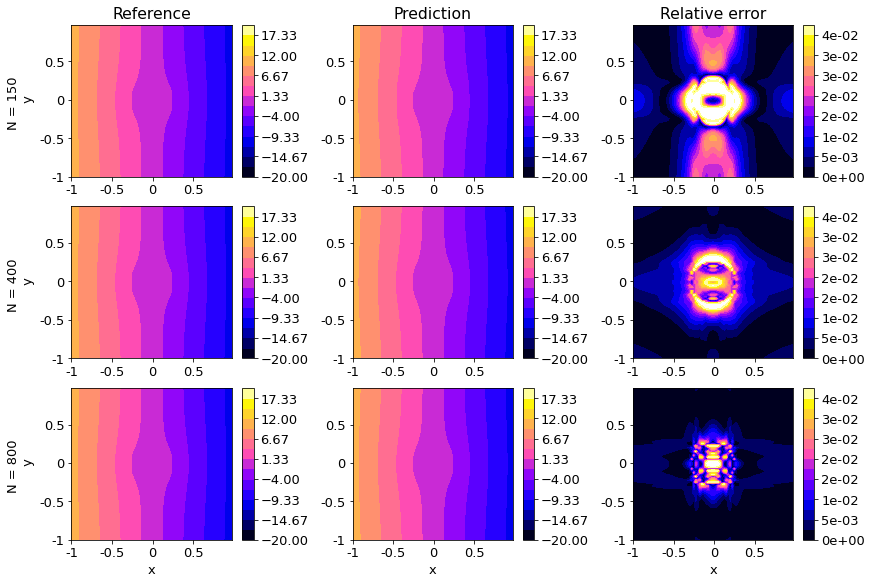

In [8]:
# Plot 3 random test realizations with predictions and error

plt.rcParams.update({'font.size': 13})

fig, axs = plt.subplots(3, 3, figsize=(12, 8), constrained_layout=True)
cm = ['gnuplot2'] * 3
j = 0
k = 4
for row in range(3):
    for col in range(3):
        ax = axs[row, col]
        if col == 0:
            pcm = ax.contourf(Y_real[j][k], levels=np.linspace(-20, 20, 16), cmap=cm[col])
            cbar = plt.colorbar(pcm, ax=ax)
            ax.set_xticklabels([-1,-0.5,0,0.5,1, 1.5])
            ax.set_yticklabels([-1,-0.5,0,0.5,1, 1.5])
            #cbar.ax.locator_params(nbins=5)
        if col == 1:
            pcm = ax.contourf(Y_recon[j][k], levels=np.linspace(-20, 20, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax)
            ax.set_xticklabels([-1,-0.5,0,0.5,1, 1.5])
            ax.set_yticklabels([-1,-0.5,0,0.5,1, 1.5])
        if col == 2:
            pcm = ax.contourf(Diff[j][k], levels=np.linspace(0, 0.04, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax, format='%.0e')
            ax.set_xticklabels([-1,-0.5,0,0.5,1, 1.5])
            ax.set_yticklabels([-1,-0.5,0,0.5,1, 1.5])
        if col == 0:
            ax.set_ylabel('N = {} \n y'.format(n_samples_[row]))
        if col ==0 and row ==0:
            ax.set_title('Reference')
        if col == 1 and row==0:
            ax.set_title('Prediction')
        if col == 2 and row==0:
            ax.set_title('Relative error')
        if row == 2:
            ax.set_xlabel('x')
    j += 1

#fig.suptitle('Test realizations for 3 training realizations', fontsize=24)
plt.savefig('figures/Example1/Comparison-cylinder.png', bbox_inches='tight', dpi=500)

In [9]:
# In addition to the above we'll show a Table with the mean and std of the l2 and r2 values for the 10,000 samples
# Compute the values next

# Compute mean and variance of errors
l2_mean = [np.round(np.mean(L2[i]), 6) for i in range(len(L2))]
l2_std = [np.round(np.std(L2[i]), 6) for i in range(len(L2))]

R2_mean = [np.round(np.mean(R2[i]), 6) for i in range(len(R2))]
R2_std = [np.round(np.std(R2[i]), 6) for i in range(len(R2))]

for i in range(3):
    print('Training data: {}'.format(n_samples_[i]))
    print('L2 mean {:e} '.format(l2_mean[i]))
    print('L2 std: {:e} '. format(l2_std[i]))
    print('R2 mean: {:e} '.format(R2_mean[i]))
    print('R2 std: {:e} '.format(R2_std[i]))
    print('')

Training data: 150
L2 mean 6.704000e-03 
L2 std: 4.071000e-03 
R2 mean: 9.999380e-01 
R2 std: 8.000000e-05 

Training data: 400
L2 mean 4.967000e-03 
L2 std: 2.644000e-03 
R2 mean: 9.999680e-01 
R2 std: 3.900000e-05 

Training data: 800
L2 mean 4.980000e-03 
L2 std: 2.689000e-03 
R2 mean: 9.999680e-01 
R2 std: 4.000000e-05 



### Moment estimation (UQ)
Comparison with MCS

Compute mean field with MCS and GDMaps PCE

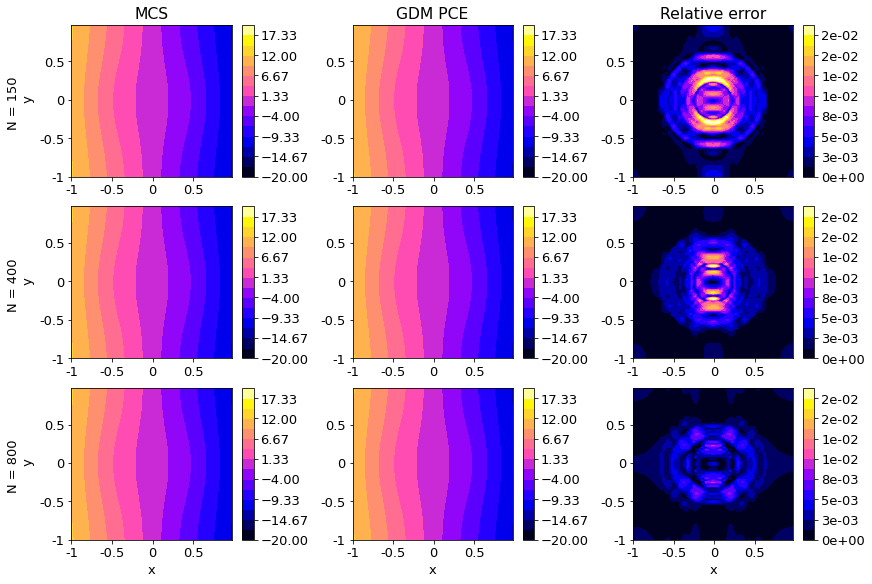

In [10]:
### Make one figure to compare the three different training data

mean_recon, mean_mcs, mean_diff = [], [], []

for i in range(len(n_samples_)):
    
    mean_recon.append(np.mean(np.array(Y_recon[i]), axis=0))
    mean_mcs.append(np.mean(np.array(Y_real[i]), axis=0))
    mean_diff.append(np.abs((mean_mcs[i] - mean_recon[i]) / mean_mcs[i]))
    
plt.rcParams.update({'font.size': 13})
j = 0
fig, axs = plt.subplots(len(n_samples_), 3, figsize=(12, 8), constrained_layout=True)
cm = ['gnuplot2'] * len(n_samples_)
for col in range(3):
    for row in range(len(n_samples_)):
        ax = axs[row, col]
        if col == 0:
            pcm = ax.contourf(mean_mcs[row+j], levels=np.linspace(-20, 20, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax)
            ax.set_xticklabels([-1,-0.5,0,0.5,1, 1.5])
            ax.set_yticklabels([-1,-0.5,0,0.5,1, 1.5])
        if col == 1:
            pcm = ax.contourf(mean_recon[row+j], levels=np.linspace(-20, 20, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax)
            ax.set_xticklabels([-1,-0.5,0,0.5,1, 1.5])
            ax.set_yticklabels([-1,-0.5,0,0.5,1, 1.5])
        if col == 2:
            pcm = ax.contourf(mean_diff[row+j], levels=np.linspace(0, 0.02, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax, format='%.0e')
            ax.set_xticklabels([-1,-0.5,0,0.5,1, 1.5])
            ax.set_yticklabels([-1,-0.5,0,0.5,1, 1.5])
        if col == 0:
            ax.set_ylabel('N = {} \n y'.format(n_samples_[row]))
        if col ==0 and row ==0:
            ax.set_title('MCS')
        if col == 1 and row==0:
            ax.set_title('GDM PCE')
        if col == 2 and row==0:
            ax.set_title('Relative error')
        if row == 2:
            ax.set_xlabel('x')
plt.savefig('figures/Example1/Mean-comparison-cylinder.png', bbox_inches='tight', dpi=500)

Compute variance field with MCS and GDMaps PCE

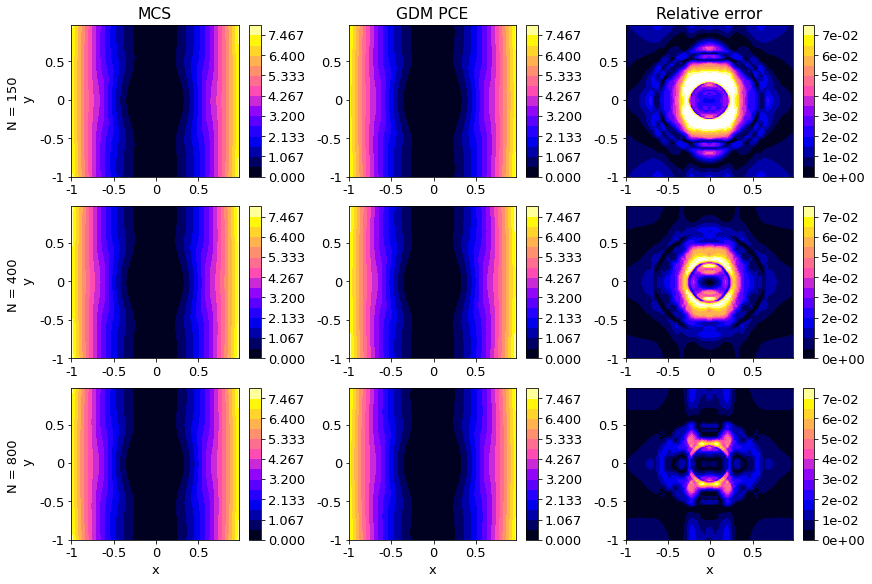

In [11]:
### Make one figure to compare the three different training data

var_recon, var_mcs, var_diff = [], [], []

for i in range(len(n_samples_)):

    var_recon.append(np.var(np.array(Y_recon[i]), axis=0))
    var_mcs.append(np.var(np.array(Y_real[i]), axis=0))
    var_diff.append(np.abs((var_mcs[i] - var_recon[i]) / var_mcs[i]))

plt.rcParams.update({'font.size': 13})

fig, axs = plt.subplots(len(n_samples_), 3, figsize=(12, 8), constrained_layout=True)
cm = ['gnuplot2'] * len(n_samples_)
for col in range(3):
    for row in range(len(n_samples_)):
        ax = axs[row, col]
        if col == 0:
            pcm = ax.contourf(var_mcs[row], levels=np.linspace(0, 8, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax)
            ax.set_xticklabels([-1,-0.5,0,0.5,1])
            ax.set_yticklabels([-1,-0.5,0,0.5,1])
        if col == 1:
            pcm = ax.contourf(var_recon[row], levels=np.linspace(0, 8, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax)
            ax.set_xticklabels([-1,-0.5,0,0.5,1, 1.5])
            ax.set_yticklabels([-1,-0.5,0,0.5,1, 1.5])
        if col == 2:
            pcm = ax.contourf(var_diff[row], levels=np.linspace(0, 0.08, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax, format='%.0e')
            ax.set_xticklabels([-1,-0.5,0,0.5,1, 1.5])
            ax.set_yticklabels([-1,-0.5,0,0.5,1, 1.5])
        if col == 0:
            ax.set_ylabel('N = {} \n y'.format(n_samples_[row]))
        if col ==0 and row ==0:
            ax.set_title('MCS')
        if col == 1 and row==0:
            ax.set_title('GDM PCE')
        if col == 2 and row==0:
            ax.set_title('Relative error')
        if row == 2:
            ax.set_xlabel('x')
plt.savefig('figures/Example1/Variance-comparison-cylinder.png', bbox_inches='tight', dpi=500)

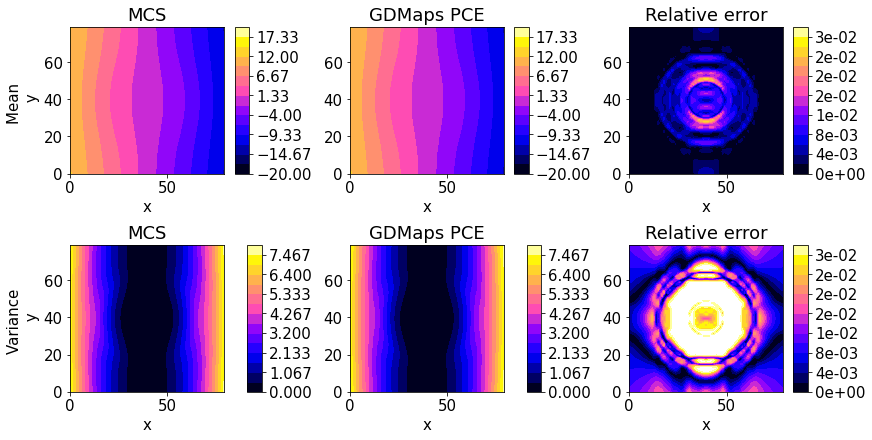

In [12]:
### Moment estimation for n_samples_[0] training data
plt.rcParams.update({'font.size': 15})

fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
cm = ['gnuplot2'] * len(n_samples_)
for col in range(3):
    for row in range(2):
        ax = axs[row, col]
        if col == 0 and row == 0:
            pcm = ax.contourf(mean_mcs[0], levels=np.linspace(-20, 20, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax)
        if col == 1 and row == 0:
            pcm = ax.contourf(mean_recon[0], levels=np.linspace(-20, 20, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax)
        if col == 2 and row == 0:
            pcm = ax.contourf(mean_diff[0], levels=np.linspace(0, 0.03, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax, format='%.0e')
            
        if col == 0 and row == 1:
            pcm = ax.contourf(var_mcs[0], levels=np.linspace(0, 8, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax)
        if col == 1 and row == 1:
            pcm = ax.contourf(var_recon[0], levels=np.linspace(0, 8, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax)
        if col == 2 and row == 1:
            pcm = ax.contourf(var_diff[0], levels=np.linspace(0, 0.03, 16), cmap=cm[col])
            plt.colorbar(pcm, ax=ax, format='%.0e')
            
        if col == 0:
            ax.set_title('MCS')
        if col == 0 and row == 0:
            ax.set_ylabel('Mean \n y')
        if col == 0 and row == 1:
            ax.set_ylabel('Variance \n y')
        if col == 1:
            ax.set_title('GDMaps PCE')
        if col == 2:
            ax.set_title('Relative error')
       
        ax.set_xlabel('x')
        
plt.savefig('figures/Example1/Moment-estimation.png', bbox_inches='tight', dpi=500)